# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
# !mkdir cifar10
# !curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xvzf cifar-10-python.tar.gz -C cifar10

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
X_val = X_test
y_val = y_test

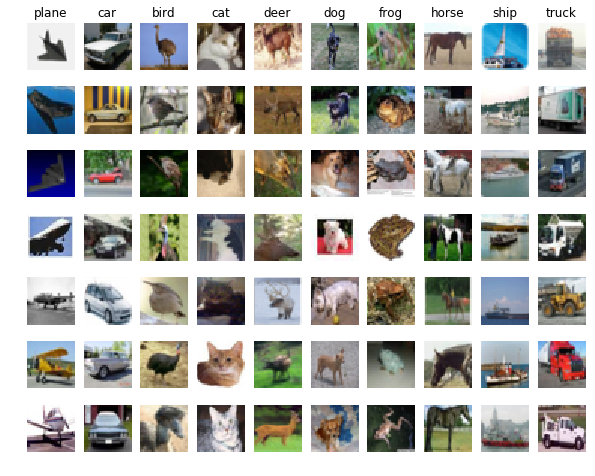

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Глубиной. Там было 4-9 слоев потом где-то 18, а сейчас уже намного больше

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Не получается хорошо посчитать градиент из-за размера, локальных минимумов так же больше

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить?

Легко переобучиться, если не использовать свертки то сеть может выродиться в наблюдение за одним пикселем.
Что можно сделать: во первых увеличить датасет с помощью разных преобразований картинок. Можно менять освещение форму, положение и т. д.. Потом использовать сверточные слои

**Вопрос 4**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?



**Вопрос 5**: Как сделать стайл трансфер для музыки? oO

Разложить в спектр преобразовать как картинку, или как-то по-другому. Нормально сейчас это вроде не умеют делать

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- http://www.robots.ox.ac.uk/~vgg/research/very_deep/
- https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Wish you get fun :)

In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *
from lasagne import init

input_X = T.tensor4("X", dtype='float32')
target_y = T.vector("target Y integer",dtype='int32')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce 940MX (CNMeM is enabled with initial size: 75.0% of memory, cuDNN not available)


In [6]:
import lasagne.layers as ll
import lasagne.nonlinearities as lnl

def add_dense_tail(net, N):
    flag = True
    while N > 10:
        net = ll.DenseLayer(net, num_units=500, nonlinearity=lnl.leaky_rectify)
        flag ^= True
        if N >= 100:
            net = ll.DropoutLayer(net, 0.5)
        N /= 10
        
    return ll.DenseLayer(net,num_units = 10, nonlinearity=softmax)

net = ll.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)

net = ll.batch_norm(ll.Conv2DLayer(net, 32, 3, pad=1, nonlinearity=lnl.leaky_rectify))

net = ll.MaxPool2DLayer(net, pool_size=(2, 2), stride=2)

net = ll.batch_norm(ll.Conv2DLayer(net, 64, 4, pad=1, nonlinearity=lnl.leaky_rectify))

net = ll.DropoutLayer(net, 0.5)
net = ll.MaxPool2DLayer(net, pool_size=(2, 2), stride=2)

net = ll.batch_norm(ll.Conv2DLayer(net, 128, 3, pad=1, nonlinearity=lnl.leaky_rectify))

net = ll.DropoutLayer(net, 0.5)

net1 = add_dense_tail(net, 100)

net = ll.DenseLayer(net,num_units = 500, nonlinearity=lnl.leaky_rectify)

net = ll.DropoutLayer(net, 0.5)

net = ll.DenseLayer(net,num_units = 300, nonlinearity=lnl.leaky_rectify)

net = ll.DropoutLayer(net, 0.5)

net = add_dense_tail(net, 200)

In [7]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)

y_predicted1 = lasagne.layers.get_output(net1)
all_weights1 = lasagne.layers.get_all_params(net1, trainable=True)

print all_weights
print all_weights1

[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b, W, b, W, b, W, b, W, b]
[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b, W, b]


In [8]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

loss1 = lasagne.objectives.categorical_crossentropy(y_predicted1, target_y).mean()
accuracy1 = lasagne.objectives.categorical_accuracy(y_predicted1, target_y).mean()

In [9]:
updates = lasagne.updates.adam(loss, all_weights, learning_rate=0.001)
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

updates1 = lasagne.updates.adam(loss1, all_weights1, learning_rate=0.001)
train_fun1 = theano.function([input_X,target_y],[loss1, accuracy1], updates=updates1, allow_input_downcast=True)
accuracy_fun1 = theano.function([input_X,target_y],accuracy1, allow_input_downcast=True)


### Вот и всё, пошли её учить

In [10]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [ ]:
import time

num_epochs_1 = 2 
num_epochs = 25 #количество проходов по данным

def learn_epoch(epoch, train_fun, accuracy_fun):
    batch_size = 50 #размер мини-батча
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        # print("F",train_err_batch, train_acc_batch)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    
for epoch in range(-num_epochs_1, 0):
    learn_epoch(epoch, train_fun1, accuracy_fun1)
    
for epoch in range(num_epochs):
    learn_epoch(epoch, train_fun, accuracy_fun)

Epoch -1 of 25 took 123.312s
  training loss (in-iteration):		0.797844
  train accuracy:		72.69 %
  validation accuracy:		73.49 %
Epoch 0 of 25 took 123.300s
  training loss (in-iteration):		0.674232
  train accuracy:		76.26 %
  validation accuracy:		73.76 %
Epoch 1 of 25 took 126.627s
  training loss (in-iteration):		0.717455
  train accuracy:		76.13 %
  validation accuracy:		72.83 %
Epoch 2 of 25 took 126.625s
  training loss (in-iteration):		0.685711
  train accuracy:		77.38 %
  validation accuracy:		72.86 %
Epoch 3 of 25 took 126.711s
  training loss (in-iteration):		0.670889
  train accuracy:		78.05 %
  validation accuracy:		72.80 %
Epoch 4 of 25 took 126.852s
  training loss (in-iteration):		0.642065
  train accuracy:		78.92 %
  validation accuracy:		73.73 %
Epoch 5 of 25 took 126.630s
  training loss (in-iteration):		0.621173
  train accuracy:		79.60 %
  validation accuracy:		74.05 %
Epoch 6 of 25 took 126.622s
  training loss (in-iteration):		0.605159
  train accuracy:		79.96 %

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 